# Estimate service interruptions in the commuter rails

# 1) Data collection and cleaning
Extract information from the MBTA API https://www.mbta.com/developers/v3-api/streaming

In [ ]:
import glob
import requests
import json
import pickle
import requests
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pprint
import tqdm
import os

Collect information from the MBTA API for the past alerts from Nov 2017 to Nov 2019 (only available data from them)

In [ ]:
from datetime import timedelta, date
from calendar import monthrange
from datetime import datetime, timedelta

def monthdelta(d1, d2):
    delta = 0
    while True:
        mdays = monthrange(d1.year, d1.month)[1]
        d1 += timedelta(days=mdays)
        if d1 <= d2:
            delta += 1
        else:
            break
    return delta

def daterange(start_date, end_date):
    for n in range(monthdelta(start_date,end_date)):
        yield start_date + timedelta(n*31)

start_date = date(2017, 11, 8)
end_date = date(2019, 12, 8)
list_timestamps_2years=list()
for single_date in daterange(start_date, end_date):
    list_timestamps_2years.append(int(datetime(*single_date.timetuple()[:-4]).timestamp()))

In [ ]:
request_lists_CR=list()
response_lists_CR=list()
for i in tqdm.tqdm_notebook(range(len(list_timestamps_2years)-1)):
  for j in tqdm.tqdm_notebook(range (0,len(commuter_rails))):
    api_keys=f"http://realtime.mbta.com/developer/api/v2.1/pastAlerts?api_key=wX9NwuHnZU2ToO7GmGR9uw&format=json&from_datetime={list_timestamps_2years[i]}&to_datetime={list_timestamps_2years[i+1]}&route={commuter_rails[j]}"
    request_lists_CR.append(api_keys)
    response_lists_CR.append(requests.get(api_keys).json())

This let me get information about all past alerts specifically for 12 commuter rails for 24 months. Nov 2017 - Nov 2019  

In [ ]:
#Save the data to a pkl file. The files are small and can be read easily
with open('/content/gdrive/My Drive/mbta_past_alerts_CR3.pkl', 'wb') as f:
  pickle.dump(response_lists_CR, f)

In [ ]:
with open('/content/gdrive/My Drive/mbta_past_alerts_CR.pkl', 'rb') as f: 
    mynewlist = pickle.load(f)
    mynewlist

In [ ]:
#Active period gives you an idea of the validity of the problem. Peak times: Monday – Friday, 7 – 9 AM and 4 – 7 PM
#All 12 trains
commuter_rails=['CR-Lowell','CR-Fitchburg','CR-Framingham','CR-Worcester', 'CR-Franklin', 
                'CR-Greenbush', 'CR-Haverhill','CR-Kingston','CR-Middleborough','CR-Needham',
                'CR-Newburyport','CR-Providence']

In [ ]:
#Checking the total cases to see if there is signal. There were ~33000 cases of service alerts
total_cases=list()
for i in range (len(mynewlist)):
  print(len(mynewlist[i]['past_alerts']))
  total_cases.append(int(len(mynewlist[i]['past_alerts'])))
  #print(i)
sum(total_cases)

In [ ]:
#Collecting all the meaningful information and placing it in one dataframe

trains=list()
service_alert_df_causes=list()
service_alert_df_effect=list()
service_alert_df_description=list()
service_alert_df_header=list()
service_alert_df_trip_id=list()
service_alert_df_start=list()
service_alert_df_stop=list()

for i in range (0,len(mynewlist)): #each train (16) for 24 months 384 datasets
  for j in range(0,len(mynewlist[i]['past_alerts'])): #first train
    if len(mynewlist[i]['past_alerts'][j]['alert_versions']) != 0:
      trains.append(mynewlist[i]['past_alerts'][j]['alert_versions'][0]['informed_entity'][0]['route_id'])
      service_alert_df_causes.append(mynewlist[i]['past_alerts'][j]['alert_versions'][0]['cause'])
      service_alert_df_effect.append(mynewlist[i]['past_alerts'][j]['alert_versions'][0]['effect'])
      service_alert_df_description.append(mynewlist[i]['past_alerts'][j]['alert_versions'][0].get('description_text',None))
      service_alert_df_header.append(mynewlist[i]['past_alerts'][j]['alert_versions'][0].get('header_text',None))
      service_alert_df_trip_id.append(mynewlist[i]['past_alerts'][j]['alert_versions'][0]['informed_entity'][0].get('trip_id',None))
      service_alert_df_start.append(mynewlist[i]['past_alerts'][j]['alert_versions'][0]['valid_from'])
      service_alert_df_stop.append(mynewlist[i]['past_alerts'][j]['alert_versions'][0]['valid_to'])


Information collected: Route ids, Causes, Effects, Description text, Headers, Trip Id for Direction, Valid to and valid from to get the duration of the alert.

In [ ]:
#Saved the data onto a dataframe
for i in range(0, len(service_alert_df_start)): 
  service_alert_df_start[i] = int(service_alert_df_start[i]) 
for i in range(0, len(service_alert_df_stop)): 
  service_alert_df_stop[i] = int(service_alert_df_stop[i]) 

two_yrs_df=pd.DataFrame(list(zip(trains, service_alert_df_causes,service_alert_df_effect,service_alert_df_description,service_alert_df_header,service_alert_df_trip_id,service_alert_df_start,service_alert_df_stop)),
                 columns=['Trains', 'Cause','Effect','Description','Header','Trip_ID','Start','Stop'])
two_yrs_df.to_pickle('/content/gdrive/My Drive/Two_yrs_allCR_v2.pkl')

In [ ]:
#Remove all emergency, police activity, and construction issues from the service alert list
two_yrs_unpickled_df = pd.read_pickle('/content/gdrive/My Drive/Two_yrs_allCR_v2.pkl')
two_yrs_unpickled_df.Cause.unique()
mask1 = two_yrs_unpickled_df['Cause'] != 'CONSTRUCTION' 
mask2 = two_yrs_unpickled_df['Cause'] != 'POLICE_ACTIVITY'
mask3 = two_yrs_unpickled_df['Cause'] != 'MEDICAL_EMERGENCY'
mask4 = (mask1) & (mask2)
mask5 = (mask4) & (mask3)
two_yrs_unpickled_df = two_yrs_unpickled_df[mask5]


In [ ]:
#Convert the epoch time to timestamps
service_alert_df_Start_Time=list(two_yrs_unpickled_df.Start.apply(datetime.datetime.fromtimestamp))
service_alert_df_Stop_Time=list(two_yrs_unpickled_df.Stop.apply(datetime.datetime.fromtimestamp))

In [ ]:
#Label for the hours of service interruption = Stop-start time.
two_yrs_unpickled_df['Service_Interruption_StartTime'] = service_alert_df_Start_Time
two_yrs_unpickled_df['Service_Interruption_StopTime'] = service_alert_df_Stop_Time

In [ ]:
#Calculating the hours of service interruption
hours_of_service_interruption=[]
two_yrs_unpickled_df['Total_Hours_of_Service_Interruption'] = two_yrs_unpickled_df['Service_Interruption_StopTime'] - two_yrs_unpickled_df['Service_Interruption_StartTime']
two_yrs_unpickled_df['Total_Hours_of_Service_Interruption']=two_yrs_unpickled_df['Total_Hours_of_Service_Interruption']/np.timedelta64(1,'h')

In [ ]:
#Found names that needed to be cleaned to get the train IDs. Made a function to handle all of them but it needed 
#more modifications than necessary for eg.,'CR-Weekday-Spring-19-707-AmtrakSwitch'
weird_name = 'CR-Weekday-Spring-19-707-AmtrakSwitch'

def strangenames2(weird_name):
  if weird_name != None:
    weird_name = str(weird_name)
    listofnumbers = [int(s) for s in weird_name.split("-") if s.isdigit()]
    if len(listofnumbers) >1:
      return int(listofnumbers[1])
    elif len(listofnumbers) == 0:
      raise ValueError(weird_name)
    else: return int(listofnumbers[0])
  else: 
    return 0
  
def strangenames(weird_name):
  if weird_name != None:
    if 'ExtremeReduced' in str(weird_name).split("-"):
      return int(str(weird_name).split("-")[2])
    elif 'April16' in str(weird_name).split("-"):
      return int(str(weird_name).split("-")[3])
    elif 'April21' in str(weird_name).split("-"):
      return int(str(weird_name).split("-")[3])
    elif 'April22' in str(weird_name).split("-"):
      return int(str(weird_name).split("-")[3])
    elif 'Woll' in str(weird_name).split("-"):
      return int(str(weird_name).split("-")[3])
    else: 
      return int(str(weird_name).split("-")[4])
  else:
    return(None)

In [ ]:
two_yrs_unpickled_df['Trip_Train_ID'] = two_yrs_unpickled_df.Trip_ID.apply(strangenames)
two_yrs_unpickled_df['Trip_Train_ID'] = two_yrs_unpickled_df.Trip_ID.apply(strangenames2)

In [ ]:
#Save to a pickle file
two_yrs_unpickled_df.to_pickle('/content/gdrive/My Drive/Two_yrs_allCR.pkl')

In [ ]:
two_yrs_unpickled_df = pd.read_pickle('/content/gdrive/My Drive/Two_yrs_allCR.pkl')

In [ ]:
Two_years_group_by_time_df = two_yrs_unpickled_df
Two_years_group_by_time_df["StartTime"] = two_yrs_unpickled_df['Service_Interruption_StartTime']
Two_years_group_by_time_df = Two_years_group_by_time_df.set_index('StartTime')
Two_years_group_by_time_df['Weekday_Name'] = Two_years_group_by_time_df.index.weekday_name

Engineered a feature for peak and non-peak hours and added that as an identifier.

In [ ]:
#I binned the date based on peak/non-peak times to evaluate usage of the train. Peak times are from 7-9 am and 4-7 pm on weekdays
def ispeak(x):
  if x.Weekday_Name in ["Saturday", "Sunday"]:
    return "OFF_PEAK"
  elif (datetime.time(7,00,00) <= x.Service_Interruption_StartTime.time() <= datetime.time(9,00,00)) or (datetime.time(16,00,00) <= x.Service_Interruption_StartTime.time() <= datetime.time(19,00,00)):                                                
    return "PEAK"
  else: 
    return "PEAK"

In [ ]:
usage=list()
for i in range(0, len(Two_years_group_by_time_df)):
  usage.append(ispeak(Two_years_group_by_time_df.iloc[i]))

Two_years_group_by_time_df["Usage"] = usage 

Once the API information was cleaned, I combined this dataframe with reliability data from the MBTA performance which required scraping from the MBTA performance website https://www.mbta.com/developers/mbta-performance

In [ ]:
MBTA_reliability_df = pd.read_pickle('/content/gdrive/My Drive/MBTA_reliability.pkl')

In [ ]:
MBTA_reliability_df["Time"] = pd.to_datetime(MBTA_reliability_df["service_date"])

In [ ]:
set(list(MBTA_reliability_df.gtfs_route_id))

In [ ]:
MBTA_reliability_df["Trains"] =  MBTA_reliability_df.gtfs_route_id
MBTA_reliability_df["Usage"] =  MBTA_reliability_df.peak_offpeak_ind
MBTA_reliability_df["Year"] =  MBTA_reliability_df.Time.dt.year
MBTA_reliability_df["Month"] =  MBTA_reliability_df.Time.dt.month
MBTA_reliability_df["Day"] =  MBTA_reliability_df.Time.dt.day

In [ ]:
Two_years_group_by_time_df["Year"] =  Two_years_group_by_time_df.Service_Interruption_StartTime.dt.year
Two_years_group_by_time_df["Month"] =  Two_years_group_by_time_df.Service_Interruption_StartTime.dt.month
Two_years_group_by_time_df["Day"] =  Two_years_group_by_time_df.Service_Interruption_StartTime.dt.day

In [ ]:
#Combine data through masks and applying it on the reliability data
import tqdm
mbtadata=list()
NEW_df = pd.DataFrame()
for i in tqdm.tqdm_notebook(range(0, len(Two_years_group_by_time_df))):
  trainmask = MBTA_reliability_df['Trains'] == Two_years_group_by_time_df['Trains'][i]
  yearmask = MBTA_reliability_df['Year'] == Two_years_group_by_time_df['Year'][i]
  usagemask = MBTA_reliability_df['Usage'] == Two_years_group_by_time_df['Usage'][i]
  monthmask = MBTA_reliability_df['Month'] == Two_years_group_by_time_df['Month'][i]
  daymask = MBTA_reliability_df['Day'] == Two_years_group_by_time_df['Day'][i]
  mask1 = (trainmask) & (usagemask)
  mask2 = (mask1) & (yearmask)
  mask3 = (mask2) & (monthmask)
  mask4 = (mask3) & (daymask)
  if mask4.sum()>0:
    NEW_df = NEW_df.append(MBTA_reliability_df[mask4].iloc[0,:])
    mbtadata.append(i)

In [ ]:
x_df = Two_years_group_by_time_df.iloc[mbtadata,:]
x_df.reset_index(drop=True, inplace=True)
NEW_df.reset_index(drop=True, inplace=True)
z = pd.concat([x_df, NEW_df], axis = 1)

Engineered the Reliability metric from MBTA performance data and proceeded to remove some unnecessary columns that were repeated.

In [ ]:
z['Reliability']=z.otp_numerator/z.otp_denomi_tor
z1 = z.iloc[:, [j for j, c in enumerate(z.columns) if j != 21]]
z2 = z1.iloc[:, [j for j, c in enumerate(z1.columns) if j != 17]]
z3 = z2.iloc[:, [j for j, c in enumerate(z2.columns) if j != 17]]
z4 = z3.iloc[:, [j for j, c in enumerate(z3.columns) if j != 20]]
z5 = z4.iloc[:, [j for j, c in enumerate(z4.columns) if j != 19]]

Merged the frequency data of the movement of the trains from the schedule of the MBTA commuter rails.

In [ ]:
freq_of_train = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Frequency_of_train.csv')
z_withfreq = pd.merge(z5, freq_of_train, on=['Trains','Weekday_Name'], how= 'outer')

In [ ]:
#Encoded dummy variables for peak/non-peak
dummies=pd.get_dummies(z_withfreq['Usage'])
z_withfreq = z_withfreq.join(dummies)
z_withfreq.to_pickle('/content/gdrive/My Drive/Two_years_group_by_time_withreliability__withfreq_allCR.pkl')

Combining this data with weather scraped from NOAA.

In [ ]:
#Adding weather data
weather = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/weather.csv')

In [ ]:
#In order to merge effectively, it was necessary to add a 
   #few extra columns to the weather data that matched with the original dataframe
weather['Time'] = pd.to_datetime(weather.DATE, utc=True)
weather['Year'] = weather['Time'].dt.year
weather['Month'] = weather['Time'].dt.month
weather['Day'] = weather['Time'].dt.day
z_withfreq_weather = pd.merge(z_withfreq, weather, on=['Year', 'Month', 'Day'], how = "left")

In [ ]:
#Handling train ids. Converted train ids into directionality: Outbound or Inbound
OutorIn=list()
for i in range(0, len(z_withfreq_weather)):
  if z_withfreq_weather.Trip_Train_ID[i] % 2 == 0 and z_withfreq_weather.Trip_Train_ID[i] != 0: #even
    OutorIn.append('Inbound')
  elif z_withfreq_weather.Trip_Train_ID[i] % 2 != 0 and z_withfreq_weather.Trip_Train_ID[i] != 0: #odd
    OutorIn.append('Outbound')
  else: 
    OutorIn.append('Both')
z_withfreq_weather['Direction'] = pd.DataFrame(OutorIn)

In [ ]:
Outbound = list()
Inbound = list()
for i in range(0, len(z_withfreq_weather)):
  if z_withfreq_weather['Direction'][i] == 'Inbound' :
    Outbound.append(0)
    Inbound.append(1)
  elif z_withfreq_weather['Direction'][i] == 'Outbound':
    Outbound.append(1)
    Inbound.append(0)
  elif z_withfreq_weather['Direction'][i] == 'Both':
    Outbound.append(1)
    Inbound.append(1)
  else:
    Outbound.append(0)
    Inbound.append(0)
    
z_withfreq_weather['Outbound'] = pd.DataFrame(Outbound)
z_withfreq_weather['Inbound'] = pd.DataFrame(Inbound)

Adding ridership data extrapolated from MBTA blue books and surveys.

In [ ]:
ridership = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Ridership.csv')
ridership = ridership[["Trains" , "Weekday_Name", "Ridership_2018"]]

In [ ]:
z_withfreq_weather_ridership = pd.merge(z_withfreq_weather, ridership, on=['Trains', 'Weekday_Name'], how = "left")

In [ ]:
z_withfreq_weather_ridership['Service_Interruption_StartTime'].dt.hour.plot.hist(bins=6)
z_withfreq_weather_ridership['Total_Hours_of_Service_Interruption']

In [ ]:
z_withfreq_weather_ridership.Reliability= z_withfreq_weather_ridership.Reliability.fillna(0)

This data was binned in 2 hr intervals for every train. This was done to avoid regressing every datum into a continuous model.The trains had different frequencies of alerts and movement. 2 hr bins were ideal because it was broad enough to account for all trains. So, for each day, data was collected and binned into 12-2 AM, 2-4 AM, 4-6 AM, etc. 0s were added to the empty bins. 

In [ ]:
#Try applying bins of 2 hrs over the day and fill with 0 s
from __future__ import division
Super_dict = {}
Super_dict["Trains"] =list()
Super_dict["Year"] = list()
Super_dict["Month"] = list()
Super_dict["Day"] = list()
Super_dict["Weekday_Name"] =list()
Super_dict["Hour"] = list()
Super_dict["Reliability"] = list()
Super_dict["Frequency"] = list()
Super_dict["Peak"] = list()
Super_dict["Outbound"] = list()
Super_dict["Inbound"] = list()
Super_dict["Temperature"] = list()
Super_dict["Snow"] = list()
Super_dict["Wind"] = list()
Super_dict["Precipitation"] = list()
Super_dict["Ridership_2018"] = list()
Super_dict["TotalServiceAlerts"]=list()
Super_dict["Total_Hours_of_Service_Interruption"] = list()

for train in set(z_withfreq_weather_ridership["Trains"]):
  print(train)
  train_mask = z_withfreq_weather_ridership["Trains"] == train
  TRAIN_df = z_withfreq_weather_ridership[train_mask]
  for yr in [2017, 2018, 2019]:
    yearmask = TRAIN_df["Year"] == yr
    for month in range (1,13):
      monthmask = TRAIN_df['Month'] == month
      for day in range (1, 32):
        daymask = TRAIN_df['Day'] == day
        mask1 = (yearmask) & (monthmask) 
        mask = (mask1) &(daymask)
        if mask.sum() > 0:
          day_df = TRAIN_df[mask]
          for ting in range(12):   #12 bins for a day; 2 hrs each 
            pre_hour_mask = day_df['Service_Interruption_StartTime'].dt.hour >= ting*2
            post_hour_mask = day_df['Service_Interruption_StartTime'].dt.hour < (ting+1)*2
            hour_mask = (pre_hour_mask) & (post_hour_mask)
            #accumulate information in these bins but if there are none, fill with 0
            Super_dict["Trains"].append(train)
            Super_dict["Year"].append(yr)
            Super_dict["Month"].append(month)
            Super_dict["Day"].append(day)
            Super_dict["Hour"].append(ting*3)
            Super_dict["Weekday_Name"].append(list(day_df['Weekday_Name'])[0])
            Super_dict["Reliability"].append(day_df['Reliability'].mean())
            Super_dict["Temperature"].append(day_df['TAVG'].mean())
            Super_dict["Snow"].append(day_df['SNOW'].mean())
            Super_dict["Wind"].append(day_df['AWND'].mean())
            Super_dict["Precipitation"].append(day_df['PRCP'].mean())
            Super_dict["Ridership_2018"].append(day_df['Ridership_2018'].mean()
            if hour_mask.sum()>0:
              df = day_df[hour_mask]
              try:
                Super_dict["Frequency"].append(len(df)/df['Frequency'].mean())
              except ZeroDivisionError:
                Super_dict["Frequency"].append(0)
              Super_dict["Peak"].append(df['PEAK'].mean())
              Super_dict["Outbound"].append(df['Outbound'].mean())
              Super_dict["Inbound"].append(df['Inbound'].mean())
              Super_dict["TotalServiceAlerts"].append(len(df))
              if df['Total_Hours_of_Service_Interruption'].mean() < 2:
                Super_dict["Total_Hours_of_Service_Interruption"].append(df['Total_Hours_of_Service_Interruption'].mean())
              else:
                Super_dict["Total_Hours_of_Service_Interruption"].append(2) 
              #print(ting*4, (ting+1)*4)
            else:
              Super_dict["Frequency"].append(0)
              if ting in [2, 5]:
                Super_dict["Peak"].append(1)
              else:Super_dict["Peak"].append(0)
              Super_dict["Outbound"].append(1)
              Super_dict["Inbound"].append(1)
              Super_dict["TotalServiceAlerts"].append(0)
              Super_dict["Total_Hours_of_Service_Interruption"].append(0)
          #print(Super_dict)
          #1/0

Made a dictionary to collect all the beneficial information but categorizing them based on trains. The features include:
Trains, Month, Day, Relaibility, Frequency (adjusted to alerts and the number of rides), Peak/Nonpeak, Inbound/Outbound, Weahter, and the response variable. I tried 2, 3, 4 hr bins and 2 hr bins worked well. So this code only shows the information for 2 hr intervals.

In [ ]:
Super_df = pd.DataFrame(Super_dict)
Super_df.isna().sum() # check for any Nans

In [ ]:
Super_df["BinnedHours"]=Super_df.Total_Hours_of_Service_Interruption.apply(np.round) #just to check the hours of interruptions signal
Super_df["BinnedHours"].plot.hist(bins=12) #most service interruption hours range between an hour or two

Recent repairs and lasting effects of snow were accounted for by accounting for lags, I used the metric of lag of service hours and snow from the past day to inform the new day's response variable

In [ ]:
###Service interruption lag
Super_df_with_lag = pd.DataFrame()
for train in (set(Super_df["Trains"])):
  train_mask = Super_df["Trains"] == train
  TRAIN_df = Super_df[train_mask]
  s2 = TRAIN_df['Total_Hours_of_Service_Interruption']
  TRAIN_df = pd.concat([TRAIN_df, s2.shift().rename('Lag')], axis=1).fillna(0)
  Super_df_with_lag = pd.concat([Super_df_with_lag, TRAIN_df])
  #1/0
#Super_df = ["Lag_Total_Hours_of_Service_Interruption"].append(df['Total_Hours_of_Service_Interruption'].max().shift(), axis = 1)
Super_df_with_lag

###Snow lag. Shift column of snow as well to account for effects on the next day
Super_df_with_lag_hours_snow = pd.DataFrame()
for train in (set(Super_df_with_lag["Trains"])):
  train_mask = Super_df_with_lag["Trains"] == train
  TRAIN_df = Super_df_with_lag[train_mask]
  s2 = TRAIN_df['Snow']
  TRAIN_df = pd.concat([TRAIN_df, s2.shift().rename('SnowLag')], axis=1).fillna(0)
  Super_df_with_lag_hours_snow = pd.concat([Super_df_with_lag_hours_snow, TRAIN_df])
  #1/0
Super_df_with_lag_hours_snow

In [ ]:
Super_df_with_lag_hours_snow.to_pickle('/content/gdrive/My Drive/Commuter_Project_Dataset.pkl')

## Exploring features in the data

In [12]:
#Super_df_with_lag_hours_snow = pd.read_pickle('C:/Users/ritwi/Google Drive/Commuter_Project_Dataset.pkl')

In [13]:
count_alerts = Super_df_with_lag_hours_snow.groupby("Trains")[.count()] #need to normalize based on schedule
count_alerts.head()

,Year,Month,Day,Weekday_Name,Hour,Reliability,Frequency,Peak,Outbound,Inbound,Temperature,Snow,Wind,Precipitation,Ridership_2018,TotalServiceAlerts,Total_Hours_of_Service_Interruption,BinnedHours,Lag,SnowLag
Trains,,,,,,,,,,,,,,,,,,,,
CR-Fairmount,396,396,396,396,396,396,396,396,396,396,396,396,396,396,396,396,396,396,396,396
CR-Fitchburg,7968,7968,7968,7968,7968,7968,7968,7968,7968,7968,7968,7968,7968,7968,7968,7968,7968,7968,7968,7968
CR-Franklin,5952,5952,5952,5952,5952,5952,5952,5952,5952,5952,5952,5952,5952,5952,5952,5952,5952,5952,5952,5952
CR-Greenbush,4920,4920,4920,4920,4920,4920,4920,4920,4920,4920,4920,4920,4920,4920,4920,4920,4920,4920,4920,4920
CR-Haverhill,5940,5940,5940,5940,5940,5940,5940,5940,5940,5940,5940,5940,5940,5940,5940,5940,5940,5940,5940,5940


In [39]:
count_train_frequency = Super_df_with_lag_hours_snow.groupby("Trains")["Frequency"].sum()
count_train_frequency.sort_values()

Trains
CR-Fairmount         20.737500
CR-Needham           40.937500
CR-Franklin          79.588694
CR-Newburyport      106.723982
CR-Haverhill        107.380952
CR-Greenbush        108.375000
CR-Kingston         114.791667
CR-Middleborough    150.166667
CR-Providence       160.694444
CR-Worcester        179.071429
CR-Lowell           194.865385
CR-Fitchburg        284.842105
Name: Frequency, dtype: float64

In [40]:
count_train_riders = Super_df_with_lag_hours_snow.groupby("Trains")["Ridership_2018"].sum()
count_train_riders.sort_values()

Trains
CR-Fairmount          1217304.0
CR-Needham           22617972.0
CR-Kingston          30147480.0
CR-Greenbush         30178800.0
CR-Haverhill         45671604.0
CR-Middleborough     48802020.0
CR-Newburyport       60216432.0
CR-Franklin          72095592.0
CR-Fitchburg         72495000.0
CR-Lowell            74899440.0
CR-Worcester        147544224.0
CR-Providence       150224868.0
Name: Ridership_2018, dtype: float64

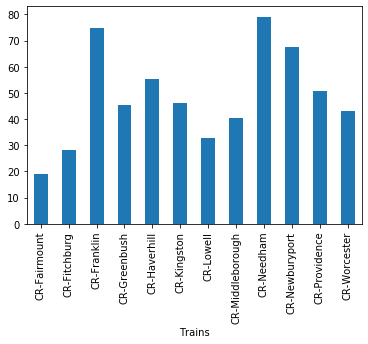

In [20]:
count_train_frequency.sort_values()
count_alerts.Year/count_train_frequency
data = pd.DataFrame(count_alerts.Year/count_train_frequency)
ax = data.plot(kind= 'bar', legend = False) #over the last two years

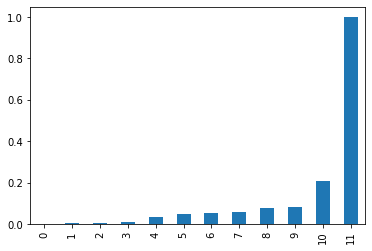

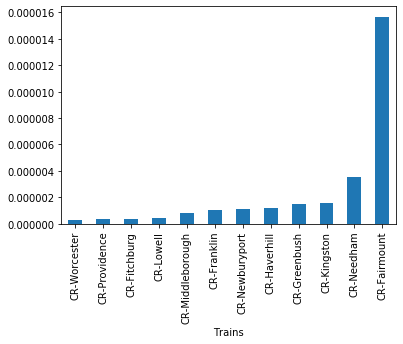

In [54]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
count_train_frequency.sort_values()
count_train_riders.sort_values()
df = count_alerts.Year/(count_train_frequency*count_train_riders)
data = pd.DataFrame(df.sort_values())
data2=pd.DataFrame(scaler.fit_transform(data))
ax = data2.plot(kind= 'bar', legend = False) #over the last two years
ax2 = data.plot(kind= 'bar', legend = False) #over the last two years

In [ ]:
count_train_frequency.sort_values()
count_alerts.Year/count_train_frequency
data = pd.DataFrame((count_alerts.Year/count_train_frequency).sort_values())
ax = data.plot(kind= 'bar', legend = False) #over the last two years

[Text(0, 0.5, 'Number of alerts normalized to frequency of trains'),
 Text(0.5, 0, 'Trains ')]

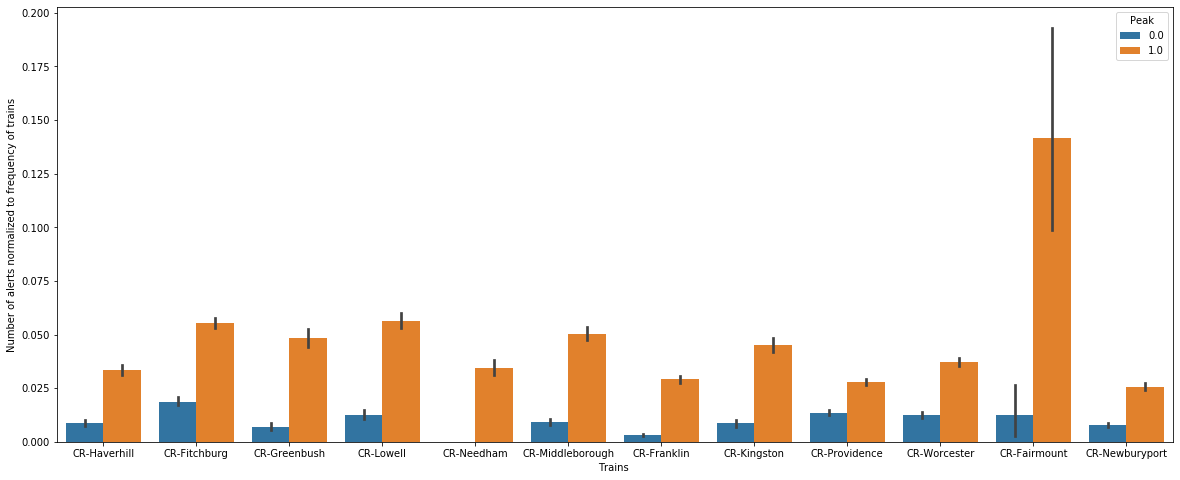

<Figure size 720x504 with 0 Axes>

In [5]:
fig, axes = plt.subplots(figsize = (20,8))
y_df = Super_df_with_lag_hours_snow['Frequency']
fig = plt.figure(figsize=(10,7))
fig = sns.barplot(x= 'Trains', y = y_df , hue = 'Peak',data = Super_df_with_lag_hours_snow, ax = axes)
fig.set(xlabel='Trains ', ylabel='Number of alerts normalized to frequency of trains')

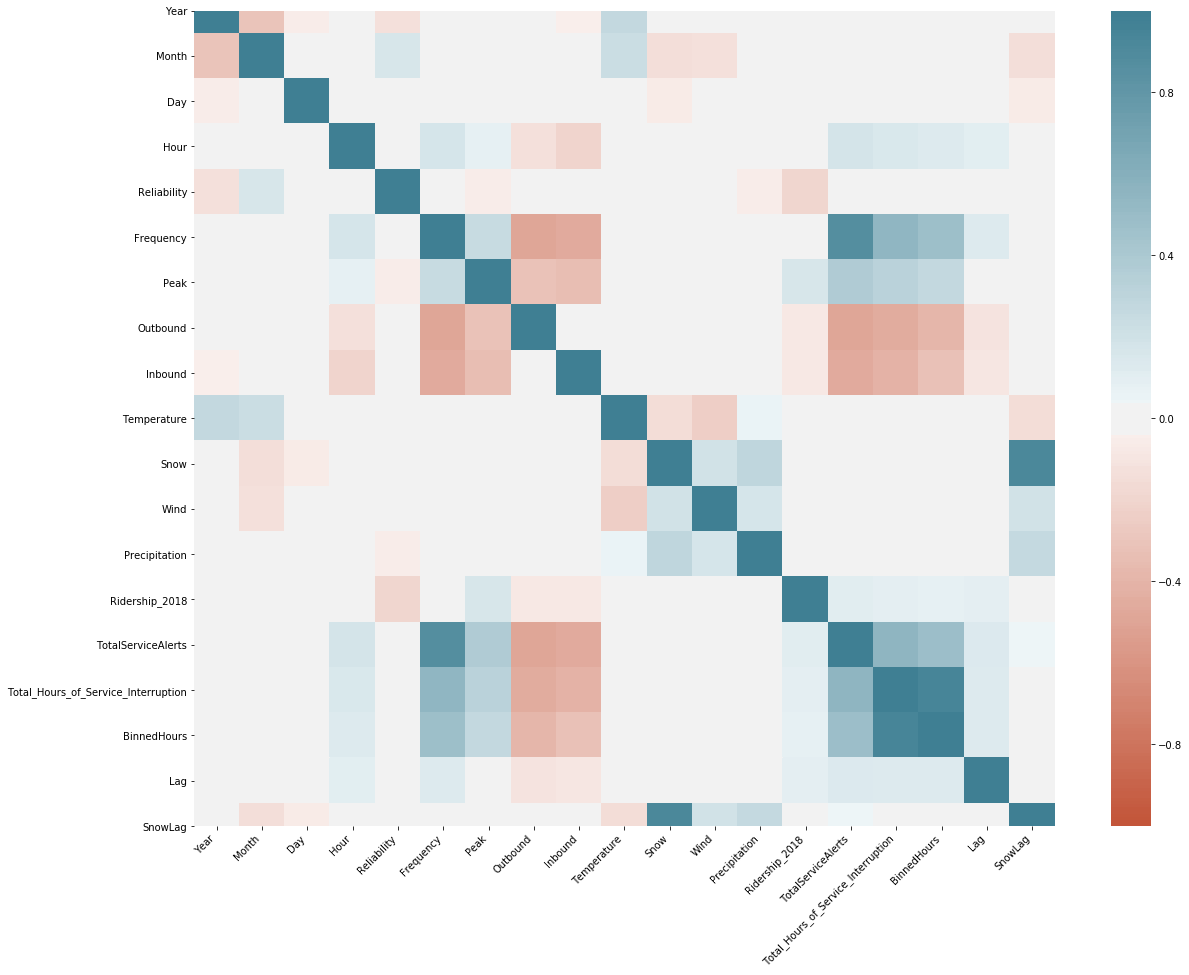

In [6]:
corr = Super_df_with_lag_hours_snow.corr()
plt.subplots(figsize=(20,15))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

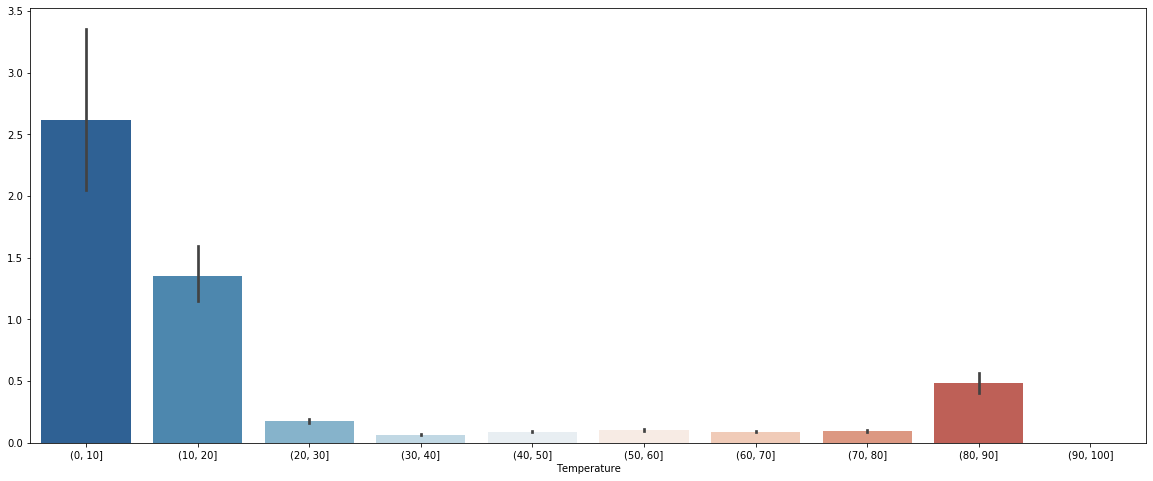

In [17]:
bins = [0, 10,20,30, 40,50, 60, 70, 80,90, 100]
x_df = pd.cut(Super_df_with_lag_hours_snow['Temperature'], bins)
#x_df.value_counts(). Take values of all columns and account for it. 
count_temp=list()
for i in range(0, len(Super_df_with_lag_hours_snow)):
  if Super_df_with_lag_hours_snow["Temperature"][i] <= 10:
    count_temp.append(816/(816+1248+5928+14412+11652+11004+11604+10248+2340))
  elif Super_df_with_lag_hours_snow["Temperature"][i] >10 and Super_df_with_lag_hours_snow["Temperature"][i] <= 20:
    count_temp.append(1248/(816+1248+5928+14412+11652+11004+11604+10248+2340))
  elif Super_df_with_lag_hours_snow["Temperature"][i] >20 and Super_df_with_lag_hours_snow["Temperature"][i] <= 30:
    count_temp.append(5928/(816+1248+5928+14412+11652+11004+11604+10248+2340))
  elif Super_df_with_lag_hours_snow["Temperature"][i] >30 and Super_df_with_lag_hours_snow["Temperature"][i] <= 40:
    count_temp.append(14412/(816+1248+5928+14412+11652+11004+11604+10248+2340))
  elif Super_df_with_lag_hours_snow["Temperature"][i] >40 and Super_df_with_lag_hours_snow["Temperature"][i] <= 50:
    count_temp.append(11652/(816+1248+5928+14412+11652+11004+11604+10248+2340))
  elif Super_df_with_lag_hours_snow["Temperature"][i] >50 and Super_df_with_lag_hours_snow["Temperature"][i] <= 60:
    count_temp.append(11004/(816+1248+5928+14412+11652+11004+11604+10248+2340))
  elif Super_df_with_lag_hours_snow["Temperature"][i] >60 and Super_df_with_lag_hours_snow["Temperature"][i] <= 70:
    count_temp.append(11604/(816+1248+5928+14412+11652+11004+11604+10248+2340))
  elif Super_df_with_lag_hours_snow["Temperature"][i] >70 and Super_df_with_lag_hours_snow["Temperature"][i] <= 80:
    count_temp.append(10248/(816+1248+5928+14412+11652+11004+11604+10248+2340))
  elif Super_df_with_lag_hours_snow["Temperature"][i] >80 and Super_df_with_lag_hours_snow["Temperature"][i] <= 90:
    count_temp.append(2340/(816+1248+5928+14412+11652+11004+11604+10248+2340))
  else:  
    count_temp.append(0)
    
Super_df_with_lag_hours_snow["Count_Temp"] = pd.DataFrame(count_temp)
fig, axes = plt.subplots(figsize = (20,8))
#x_df = Super_df_with_lag_hours_snow['Temperature']
Snow_df = Super_df_with_lag_hours_snow['Snow']
y_df = Super_df_with_lag_hours_snow['Total_Hours_of_Service_Interruption']/Super_df_with_lag_hours_snow['Count_Temp']*Super_df_with_lag_hours_snow['Frequency']
fig = sns.barplot(x = x_df, y = y_df ,data = Super_df_with_lag_hours_snow, ax = axes,  palette= "RdBu_r")

# 2) Models: applying regression on features
Testing models on the dataset with the response variable of hours of service interruptions

In [8]:
X = Super_df_with_lag_hours_snow.drop('Total_Hours_of_Service_Interruption', axis=1)
y = Super_df_with_lag_hours_snow[['Total_Hours_of_Service_Interruption']]

In [ ]:
#Encoding features
trains_dict = dict(zip(list(X["Trains"].value_counts().index), range(12)))
X['Trains'].map(trains_dict)
year_dict = dict(zip(list(X["Year"].value_counts().index), range(2017,2018,2019)))
X['Year'].map(year_dict)
month_dict = dict(zip(list(X["Year"].value_counts().index), range(12)))
X['Month'].map(month_dict)
weekday_name_day_dict = dict(zip(list(X["Weekday_Name"].value_counts().index), range(12)))
X['Weekday_Name'].map(weekday_name_day_dict)

In [10]:
trains_dummies = pd.get_dummies(X['Trains'])
year_dummies = pd.get_dummies(X['Year'])
month_dummies= pd.get_dummies(X['Month'])
weekday_name_dummies = pd.get_dummies(X['Weekday_Name'])

In [11]:
X = X.join([trains_dummies, year_dummies, month_dummies, weekday_name_dummies])
X = X.drop("Trains", axis =1)
X = X.drop("Month", axis =1)
X = X.drop("Weekday_Name", axis =1)
X = X.drop("Year", axis =1)

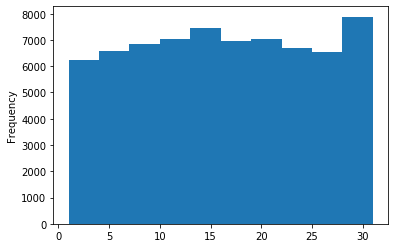

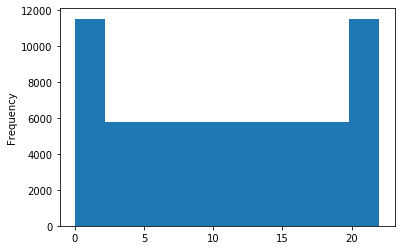

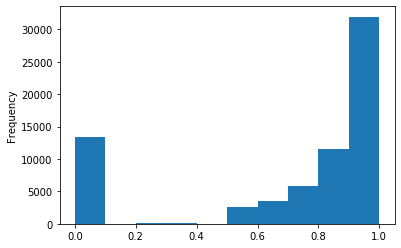

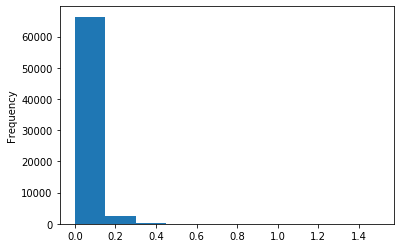

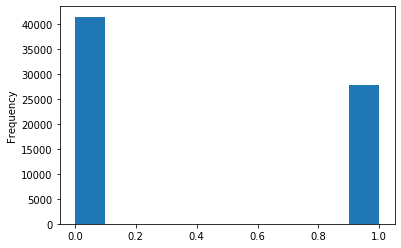

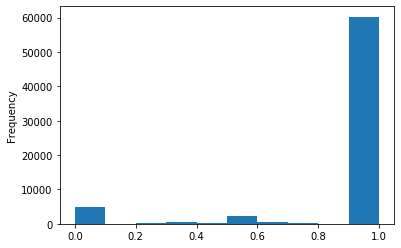

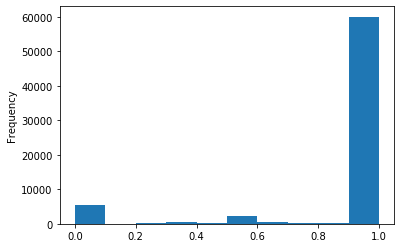

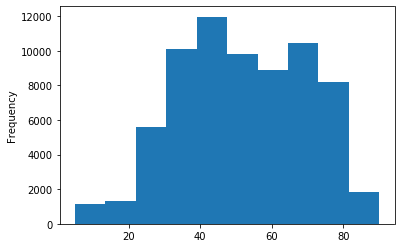

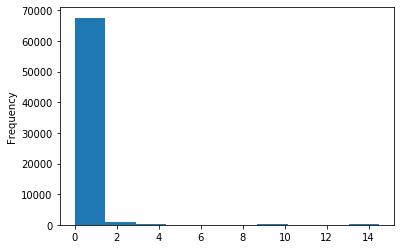

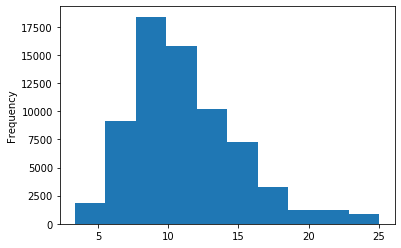

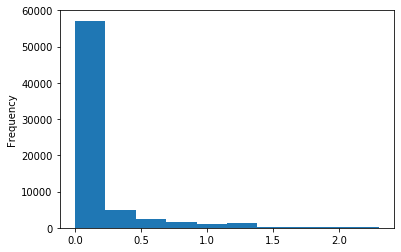

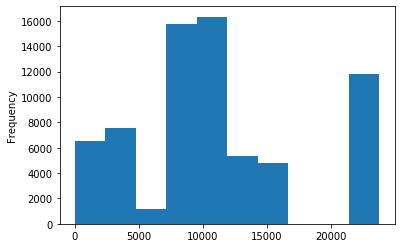

In [34]:
#Check distribution of all the features
for i, col in enumerate(X.columns[0:12]):
    plt.figure(i)
    X[col].plot.hist()
#mostly even distribution

Linear Regression across all features. 
(But this may not work as well because there are significant numbers of categorical features in the dataframe.)

In [5]:
# Load libraries necessary for the models
def LoadPackages(): pass
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from xgboost import XGBRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
%matplotlib inline

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, newy, train_size=0.8, random_state=42)
scaler = StandardScaler().fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train), index=X_train.index.values, columns=X_train.columns.values)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), index=X_test.index.values, columns=X_test.columns.values)

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 10 )
pca.fit(X_train)
cpts = pd.DataFrame(pca.transform(X_train)) 
x_axis = np.arange(1, pca.n_components_+1)

pca_scaled = PCA()
pca_scaled.fit(X_train_scaled)
cpts_scaled = pd.DataFrame(pca.transform(X_train_scaled)) #applied on training data

In [ ]:
#Applying PCA on scaled data gave a better output
# plt.plot(np.cumsum(pca_scaled.explained_variance_ratio_))
# plt.xlabel('number of components')
# plt.ylabel('cumulative explained variance');

In [ ]:
#Check score of scaled test type
from sklearn.metrics import r2_score
from scipy.stats import spearmanr, pearsonr
predicted_train = rf2.predict(X_train_scaled)
predicted_test = rf2.predict(X_test_scaled)
test_score = r2_score(y_test, predicted_test)

test_score = r2_score(y_test, predictions)
print(f'Test data R-2 score: {test_score:>5.3}')
print("Mean squared error: %.2f" % mean_squared_error(y_test, predictions))
print("Mean absolute error: %.2f" % metrics.mean_absolute_error(y_test, predictions))

In [ ]:
#Results from a regression:
# Test data R-2 score: 0.422
# Mean squared error: 0.08
# Mean absolute error: 0.13

Evaluating other regression models. This doesn't require scaling

In [ ]:
# Check Multiple Models for linear regression
models = []
def append_models():
    #models.append(('Linear Regression', LinearRegression()))


    models.append(('Random Forest Regressor', RandomForestRegressor(n_estimators = 1000, random_state=42)))
    
    models.append(('XGBoost Regressor', XGBRegressor(random_state=42,n_estimators = 500,silent=True)))

    models.append(('LightGBM', LGBMRegressor(boosting_type='gbdt', num_leaves=31, max_depth=7, learning_rate=0.1, 
                       n_estimators=70,  min_split_gain=0.0, min_child_weight=0.001, min_child_samples=20, subsample=1.0, subsample_freq=0, 
                       colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0, random_state=None, n_jobs=-1, silent=True)))

append_models()

In [ ]:
for name, model in models:
  scores_dict_fold = OrderedDict()
  scores_dict_fold['name'] = name

  predictions_overall = np.array([])
  y_test_overall = np.array([])
  conf_matrix_list = np.array([])
  X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=42)
  model.fit(X_train, y_train.values.ravel())
  predictions = model.predict(X_test)
  test_score = r2_score(y_test, predictions)
  print(f'Test data R-2 score: {test_score:>5.3}')
  print("Mean squared error: %.2f" % mean_squared_error(y_test, predictions))
  print("Mean absolute error: %.2f" % metrics.mean_absolute_error(y_test, predictions))

In [ ]:
##Random Forest
# Test data R-2 score: 0.661
# Mean squared error: 0.05
# Mean absolute error: 0.08

##XGBoost Regression
# Test data R-2 score: 0.665
# Mean squared error: 0.05
# Mean absolute error: 0.08

##LightGBM Regression (fastest!)
# Test data R-2 score: 0.674
# Mean squared error: 0.05
# Mean absolute error: 0.08

Light GBM regression: efficient, fast, and tree/leaf-based

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=42)

A GridSearchCV for hyperparameter tuning. I have maximised independence with the lag columns, so a grid CV search can be applied to this to find the best parameters

In [ ]:
from sklearn.model_selection import GridSearchCV
estimator = lgb.LGBMRegressor()
param_grid = {
    'learning_rate': [ 0.05,0.1, 0.2],
    'n_estimators': [60, 80,100,120,180],
    'num_leaves':[40,50],
    'max_depth':[15], 'subsample_for_bin':[500,1000], 'min_child_samples':[10],
}
gbm = GridSearchCV(estimator, param_grid, cv=3)
gbm.fit(X_train, y_train)
#print(gbm.cv_results_)

#print('Best parameters found by grid search are:', gbm.best_params_)

In [21]:
X.head()

,Day,Hour,Reliability,Frequency,Peak,Outbound,Inbound,Temperature,Snow,Wind,...,10,11,12,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,9,0,0.9375,0.0,0.0,1.0,1.0,41.0,0.0,7.38,...,0,1,0,0,0,0,0,1,0,0
1,9,2,0.9375,0.0,0.0,1.0,1.0,41.0,0.0,7.38,...,0,1,0,0,0,0,0,1,0,0
2,9,4,0.9375,0.0,0.0,1.0,1.0,41.0,0.0,7.38,...,0,1,0,0,0,0,0,1,0,0
3,9,6,0.9375,0.0,1.0,1.0,1.0,41.0,0.0,7.38,...,0,1,0,0,0,0,0,1,0,0
4,9,8,0.9375,0.0,1.0,1.0,1.0,41.0,0.0,7.38,...,0,1,0,0,0,0,0,1,0,0


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=42)

These are the parameters that we need to tune to make the right predictors (as discussed before, these simple predictors are decision trees):
max_depth (both XGBoost and LightGBM): This provides the maximum depth that each decision tree is allowed to have. A smaller value signifies a weaker predictor.

min_split_gain (LightGBM), gamma (XGBoost): Minimum loss reduction required to make a further partition on a leaf node of the tree. A lower value will result in deeper trees.

num_leaves (LightGBM): Maximum tree leaves for base learners. A higher value results in deeper trees.
min_child_samples (LightGBM): Minimum number of data points needed in a child (leaf) node. According to the LightGBM docs, this is a very important parameter to prevent overfitting.

subsample (both XGBoost and LightGBM): This specifies the fraction of rows to consider at each subsampling stage. By default it is set to 1, which means no subsampling.

colsample_bytree (both XGBoost and LightGBM): This specifies the fraction of columns to consider at each subsampling stage. By default, it is set to 1, which means no subsampling.

subsample_freq (LightGBM): This specifies that bagging should be performed after every k iterations. By default it is set to 0. So make sure that you set it to some non-zero value if you want to enable subsampling.

learning_rate (both XGBoost and LightGBM):
It is also called shrinkage. The effect of using it is that learning is slowed down, in turn requiring more trees to be added to the ensemble. This gives the model a regularisation effect. It reduces the influence of each individual tree and leaves space for future trees to improve the model.

In [40]:
#Testing parameters
model = lgb.LGBMRegressor(boosting_type='gbdt', num_leaves=70, max_depth=15, learning_rate=0.1, 
                       n_estimators=120, subsample_for_bin=1000,
                      min_split_gain=0,  min_child_samples=5, min_child_weight=0.0001,subsample=1.0, subsample_freq=0, 
                      colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0, random_state=42, n_jobs=-1, silent=True)

In [41]:
model.fit(X_train, y_train.values.ravel())
preds = model.predict(X_test)
from sklearn.metrics import r2_score
test_score = r2_score(y_test, preds)
print(f'Test data R-2 score: {test_score:>5.3}')
print("Mean squared error: %.2f" % mean_squared_error(y_test, preds))
print("Mean absolute error: %.2f" % metrics.mean_absolute_error(y_test, preds))

Test data R-2 score: 0.672
Mean squared error: 0.05
Mean absolute error: 0.08


C:\Users\ritwi\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='bar')` instead of `Series.plot('bar',)`.
  # Remove the CWD from sys.path while we load stuff.


Text(0.5, 1.0, 'Features importance')

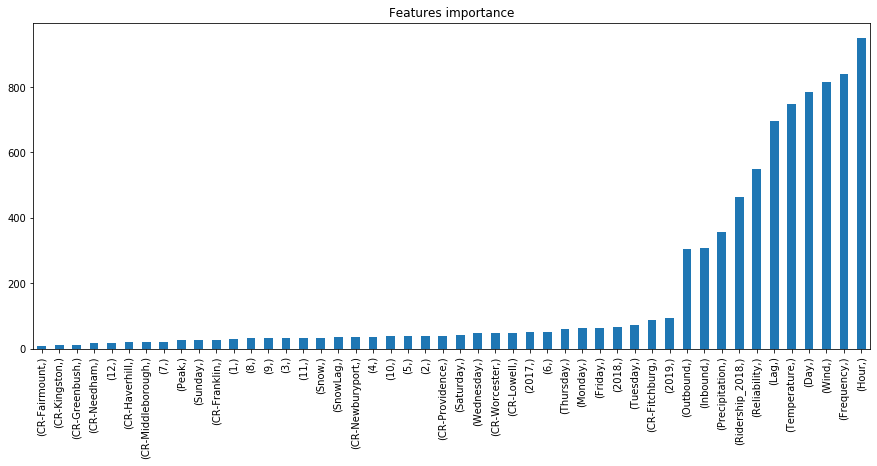

In [42]:
fet_ind = np.argsort(model.feature_importances_)#[::-1]
fet_imp = model.feature_importances_[fet_ind]
fet_ind = np.argsort(model.feature_importances_)#[::-1]
fet_imp = model.feature_importances_[fet_ind]
#Extracting feature names
feature_names = pd.DataFrame(list(X.columns))
feature_names.values[fet_ind]
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
labels = feature_names.values[fet_ind]
pd.Series(fet_imp, index=labels).plot('bar', ax=ax)
ax.set_title('Features importance')

In [ ]:
with open('/content/gdrive/My Drive/Commuter_lightgbm_model.pkl', 'wb') as f:
  pickle.dump(model, f)

A randomized grid CV search works to make the model better by randomizing the combination of hyperparameters and evaluating the combination with the best performance.

In [8]:
#grid of parameters
gridParams = {
    'learning_rate': [0.01,0.05],
    'num_leaves': [150,200, 250],
    'boosting_type' : ['gbdt'],
    'objective' : ['regression'],
    'min_child_samples':[2,5],
    'max_depth' : [7,10],
    'random_state' : [42], 
    'colsample_bytree' : [0.5, 1],
    'subsample' : [0.7, 2, 5],
    'subsample_freq':[0.5, 1 ,10,20],
    'min_split_gain' : [0.01, 0.1, 2],
    'min_data_in_leaf':[10, 20],
    'metric':['auc']
    }

In [ ]:
#modelling
from sklearn.model_selection import RandomizedSearchCV
clf = lgb.LGBMRegressor()
grid = RandomizedSearchCV(clf,gridParams,verbose=1,cv=10,n_jobs = -1,n_iter=20)
grid.fit(X_train,y_train)

In [ ]:
grid.best_params_

In [ ]:
#Testing parameters
model = lgb.LGBMRegressor(boosting_type='gbdt', num_leaves=200, max_depth=7, learning_rate=0.01, 
                       n_estimators=500, subsample_for_bin=1000,
                      min_split_gain=0.01,  min_child_samples=5,min_data_in_leaf = 5, min_child_weight=0.0001,subsample=0.7, subsample_freq=10, 
                      colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0, random_state=42, n_jobs=-1, silent=True)

In [ ]:
model.fit(X_train, y_train.values.ravel())
preds

In [ ]:
from sklearn.metrics import r2_score
test_score = r2_score(y_test, preds)
print(f'Test data R-2 score: {test_score:>5.3}')
print("Mean squared error: %.2f" % mean_squared_error(y_test, preds))
print("Mean absolute error: %.2f" % metrics.mean_absolute_error(y_test, preds))

In [ ]:
with open('/content/gdrive/My Drive/Commuter_lightgbm_model_v1.pkl', 'wb') as f:
  pickle.dump(model, f)